In [1]:
!pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip list

Package                       Version
----------------------------- ---------
absl-py                       2.1.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aiohttp-retry                 2.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.12.0
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout   

In [3]:
import tensorflow as tf
import os

In [4]:
import cv2 #opencv
import imghdr


/var/folders/s9/c04zrlkx7wv1h3wxqk4wln400000gn/T/ipykernel_5049/3019783583.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
dataDir = 'data'

In [6]:
# os.listdir(os.path.join(dataDir, 'mac')) # shows every file in the folder
os.listdir(dataDir) # shows the files inside dataDir

['.DS_Store', 'mac', '.ipynb_checkpoints', 'windows']

In [7]:
imageExtensions = ['jpeg', 'jpg', 'bmp'] # standard list of image extensions

In [8]:
for imageClass in os.listdir(dataDir): # prints folders
    if imageClass.startswith((".", "_", "U")): # skips the two hidden directories 
        continue 
    for image in os.listdir(os.path.join(dataDir, imageClass)): # loops to every image in subdirectories
        imagePath = os.path.join(dataDir, imageClass, image) # store those values inside imagePath
        try:
            img = cv2.imread(imagePath) # check you can load to opencv
            tip = imghdr.what(imagePath)
            if tip not in imageExtensions: # if it doesn't have the desired extensions, remove it
                print('Image not in ext list{}'.format(imagePath))
                os.remove(imagePath)
        except Exception as e:
            print('Issue with image{}'.format(imagePath))
                # os.remove(imagePath)

In [9]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')# creates data pipeline

Found 1622 files belonging to 2 classes.


In [12]:
dataIterator = data.as_numpy_iterator() # allows us to access data pipeline

In [13]:
# get another batch from the iterator
batch = dataIterator.next() # makes a batch of len 2, consisting of images as numpy arrays, and labels

In [14]:
# batch[0] is the images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [15]:
# batch[1] is the labels of the images in the batch, labels are what folders they come from mac = 0, windows = 1
batch[1]

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1], dtype=int32)

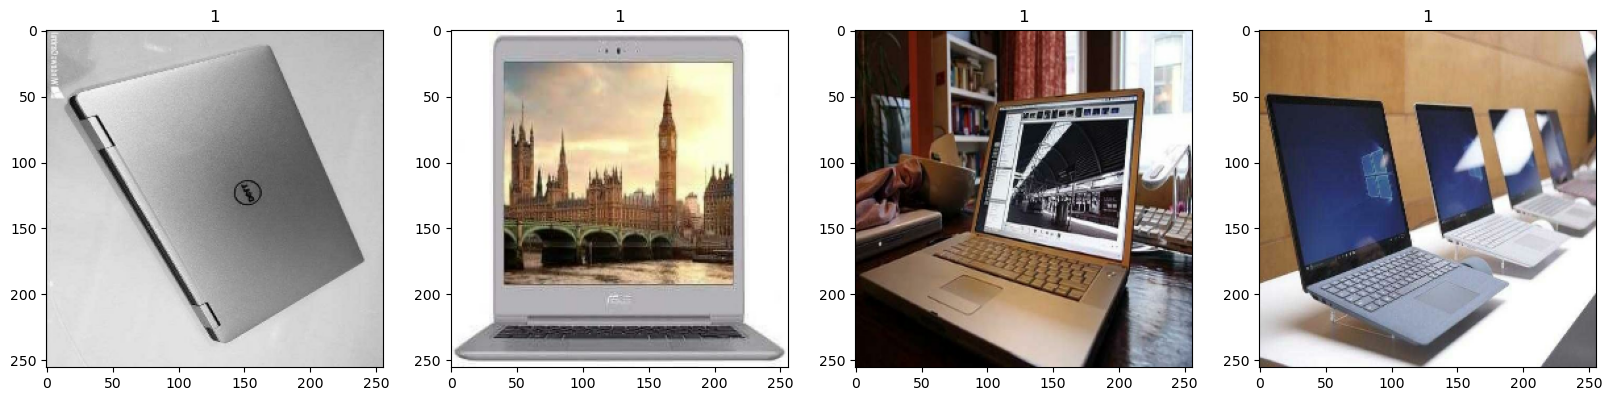

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) # this shows examples of the labels
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [17]:
# Preprocess Data

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
data.as_numpy_iterator().next()[0].max()

1.0

In [20]:
# Split Data

In [21]:
len(data)

51

In [22]:
trainSize = int(len(data)*.7)
valSize = int(len(data)*.2)+1
testSize = int(len(data)*.1)+1

In [23]:
train = data.take(trainSize)
val = data.skip(trainSize).take(valSize)
test = data.skip(trainSize+valSize).take(testSize)

In [24]:
# 3 Deep Model
# 3.1 Build Deep Learning Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2

In [26]:
model = Sequential()

In [27]:
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(8, (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [28]:
# tf.optimizers. This is a list of the other optimizers we can use

In [29]:
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [31]:
logDir = 'logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logDir)

In [33]:
# one epoch is one run through the training dataset

In [34]:
history = model.fit(train, epochs=20, validation_data =(val), callbacks = [tensorboard_callback])

Epoch 1/20
35/35 [==============================] - 18s 513ms/step - loss: 0.6658 - accuracy: 0.6375 - val_loss: 0.6647 - val_accuracy: 0.6136
Epoch 2/20
35/35 [==============================] - 18s 497ms/step - loss: 0.6475 - accuracy: 0.6348 - val_loss: 0.6101 - val_accuracy: 0.6648
Epoch 3/20
35/35 [==============================] - 18s 497ms/step - loss: 0.6331 - accuracy: 0.6420 - val_loss: 0.6272 - val_accuracy: 0.6562
Epoch 4/20
35/35 [==============================] - 18s 498ms/step - loss: 0.6162 - accuracy: 0.6580 - val_loss: 0.6010 - val_accuracy: 0.6705
Epoch 5/20
35/35 [==============================] - 18s 498ms/step - loss: 0.5625 - accuracy: 0.6911 - val_loss: 0.5461 - val_accuracy: 0.7102
Epoch 6/20
35/35 [==============================] - 17s 490ms/step - loss: 0.5058 - accuracy: 0.7348 - val_loss: 0.5570 - val_accuracy: 0.7188
Epoch 7/20
35/35 [==============================] - 17s 492ms/step - loss: 0.4650 - accuracy: 0.7652 - val_loss: 0.5726 - val_accuracy: 0.7358

In [35]:
history.history

{'loss': [0.6657844185829163,
  0.6475188732147217,
  0.6331497430801392,
  0.6162232756614685,
  0.5625321269035339,
  0.5057884454727173,
  0.4650098383426666,
  0.41414064168930054,
  0.3388087749481201,
  0.2639982998371124,
  0.2158171385526657,
  0.19429299235343933,
  0.12863197922706604,
  0.1389736384153366,
  0.08340073376893997,
  0.04295646399259567,
  0.04000071436166763,
  0.04185561463236809,
  0.050090059638023376,
  0.01924522966146469],
 'accuracy': [0.637499988079071,
  0.6348214149475098,
  0.6419642567634583,
  0.6580356955528259,
  0.6910714507102966,
  0.7348214387893677,
  0.7651785612106323,
  0.8044642806053162,
  0.8500000238418579,
  0.8973214030265808,
  0.9098214507102966,
  0.9133928418159485,
  0.9580357074737549,
  0.9473214149475098,
  0.9785714149475098,
  0.9883928298950195,
  0.9866071343421936,
  0.9937499761581421,
  0.9848214387893677,
  0.9955357313156128],
 'val_loss': [0.6646920442581177,
  0.6100731492042542,
  0.6272296905517578,
  0.6010054

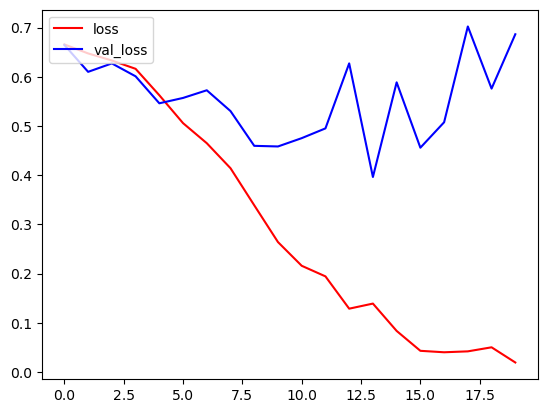

In [36]:
fir = plt.figure()
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

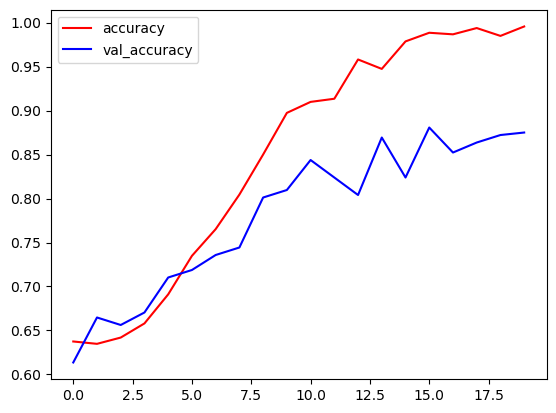

In [37]:
fir = plt.figure()
plt.plot(history.history['accuracy'], color='red', label='accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator():
    X, y = batch
    percentage = model.predict(X)
    precision.update_state(y, percentage)
    recall.update_state(y, percentage)
    accuracy.update_state(y, percentage)

1/1 [==============================] - 0s 105ms/step


In [41]:
print(f' Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

 Precision:0.8602150678634644, Recall:0.8695651888847351, Accuracy:0.8333333134651184


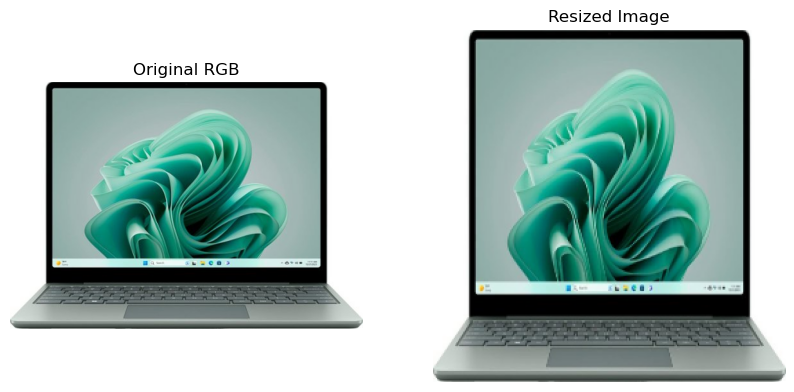

In [42]:
# Read the BGR image
img = cv2.imread('windowtest.jpeg')

# Convert BGR image to RGB
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize the RGB image
resize = tf.image.resize(rgb_img, (256, 256))

# Create a figure and two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image on the first subplot
axes[0].imshow(rgb_img)
axes[0].set_title('Original RGB')

# Plot the resized image on the second subplot
axes[1].imshow(resize.numpy().astype(int))
axes[1].set_title('Resized Image')

# Hide the axes
for ax in axes:
    ax.axis('off')

# Display the plot
plt.show()

In [43]:
percentage = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 13ms/step


In [44]:
np.expand_dims(resize, 0)

array([[[[255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         ...,
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ]],

        [[255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         ...,
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ]],

        [[255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         ...,
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ]],

        ...,

        [[249.25835, 248.94733, 246.94733],
         [249.90482, 251.15535, 248.62747],
         [236.12886, 240.53902, 237.99995],
         ...,


In [45]:
percentage

array([[0.0003673]], dtype=float32)

In [46]:
if percentage > 0.5:
    print(f'Predicted class is Window')
else:
    print(f'Predicted class is Macbook')

Predicted class is Macbook


In [47]:
# 5.1 Save the model

In [48]:
from tensorflow.keras.models import load_model

In [52]:
model.save(os.path.join('Model', 'imageclassification.h5'))

In [53]:
newModel = load_model(os.path.join('Model', 'imageclassification.h5'))

In [51]:
newModel.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 33ms/step


array([[0.0003673]], dtype=float32)